#**HW4 : Recurrent Neural Networks**
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. As a dataset, we will use the IMDB dataset. It contains the text of some reviews and the sentiment given by the authors of the reviews (positive review or negative review). The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will explore how to face overfitting by Dropout. 

## Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [ ]:

num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17465344/17464789 [==============================] - 1s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Let's also get the word indexs (word to word-id)

In [ ]:
word_index = keras.datasets.imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur.
*Please, notice that Keras does not use index 0, so we can shift the indices only by 3 positions.*

In [ ]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [ ]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [ ]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [ ]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

### Define the model:
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem

In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in model.compile() and motivate your choice.
Please, insert your answers in a new text cell below this one, immediately before the code.

The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem.
Sigmoid function is a smooth nonlinear function that maps any input to an output ranging from 0 to 1 (0 and 1 represent the 2 classes)
For this reason the output value can be interpreted as a probability and  It's suitable in case of a binary classification problem.
<br><br>As loss parameter I use BinaryCrossentropy: It Computes the cross-entropy loss between true labels and predicted labels. We use this cross-entropy loss when there are only two label classes (assumed to be 0 and 1). For each example, there should be a single floating-point value per prediction.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(units=32))
model.add(keras.layers.Dense(1, activation="sigmoid")) 

model.compile(loss="BinaryCrossentropy", optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                1376      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


###Train the model:
Now we have to train the model

In [ ]:
history = model.fit(X_train_trim, y_train,epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 98s 494ms/step - loss: 0.6905 - accuracy: 0.5266 - val_loss: 0.6512 - val_accuracy: 0.6259
Epoch 2/10
196/196 [==============================] - 96s 491ms/step - loss: 0.5691 - accuracy: 0.7234 - val_loss: 0.4548 - val_accuracy: 0.8056
Epoch 3/10
196/196 [==============================] - 96s 490ms/step - loss: 0.3382 - accuracy: 0.8579 - val_loss: 0.4229 - val_accuracy: 0.8162
Epoch 4/10
196/196 [==============================] - 98s 500ms/step - loss: 0.2317 - accuracy: 0.9120 - val_loss: 0.4257 - val_accuracy: 0.8308
Epoch 5/10
196/196 [==============================] - 98s 502ms/step - loss: 0.1623 - accuracy: 0.9419 - val_loss: 0.4341 - val_accuracy: 0.8322
Epoch 6/10
196/196 [==============================] - 97s 493ms/step - loss: 0.1153 - accuracy: 0.9624 - val_loss: 0.4933 - val_accuracy: 0.8164
Epoch 7/10
196/196 [==============================] - 98s 500ms/step - loss: 0.0628 - accuracy: 0.9841 - val_loss: 0.6369 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')


391/391 - 13s - loss: 0.6697 - accuracy: 0.8201
accuracy: 82.01%


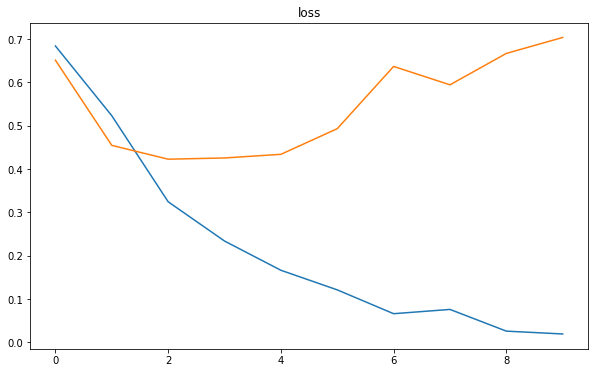

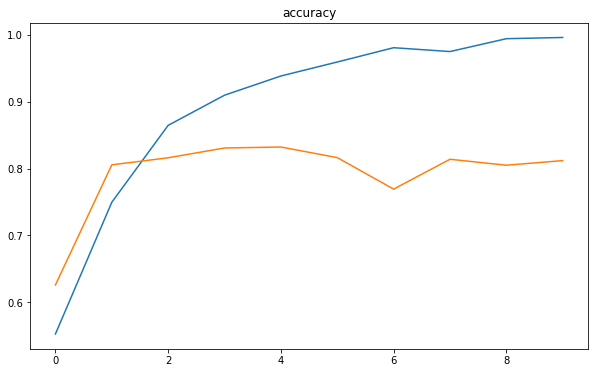

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Exercise 4.2: LSTM and GRU
In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer, respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.


In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use, respectively?


In order to perform a fair comparison between the given RNN model and the other 2 models (LSTM and GRU), we have to use these number:
<br>SimpleRNN: 32 units , 101,409 params
<br>LSTM: 14 units , 101,415 params
<br>GRU: 16 units , 101,361 params
<br><br>Performance of different models:
<br>SimpleRNN: loss: 0.6697 - accuracy: 0.8201
<br>LSTM: loss: 0.4764 - accuracy: 0.8593
<br>GRU: loss: 0.4532 - accuracy: 0.8561
<br><br>As we can see the model with LSTM have a better performance compared with the other 2 models.
<br>As we can see from the results below in the model with SimpleRNN the training phase is slower (5 times slower) than the other 2 models.
<br>All the models suffer from overfitting.

In [ ]:
#LSTM
model_LSTM = keras.models.Sequential()
model_LSTM.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_LSTM.add(keras.layers.LSTM(14))
model_LSTM.add(keras.layers.Dense(1, activation="sigmoid"))

model_LSTM.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
lstm (LSTM)                  (None, 14)                1400      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_LSTM = model_LSTM.fit(X_train_trim, y_train,epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 46s 93ms/step - loss: 0.6349 - accuracy: 0.6282 - val_loss: 0.4063 - val_accuracy: 0.8217
Epoch 2/10
196/196 [==============================] - 18s 91ms/step - loss: 0.3596 - accuracy: 0.8544 - val_loss: 0.3531 - val_accuracy: 0.8485
Epoch 3/10
196/196 [==============================] - 18s 91ms/step - loss: 0.2665 - accuracy: 0.8994 - val_loss: 0.3531 - val_accuracy: 0.8567
Epoch 4/10
196/196 [==============================] - 18s 91ms/step - loss: 0.2026 - accuracy: 0.9290 - val_loss: 0.3230 - val_accuracy: 0.8695
Epoch 5/10
196/196 [==============================] - 18s 91ms/step - loss: 0.1622 - accuracy: 0.9468 - val_loss: 0.3473 - val_accuracy: 0.8684
Epoch 6/10
196/196 [==============================] - 18s 91ms/step - loss: 0.1366 - accuracy: 0.9563 - val_loss: 0.3781 - val_accuracy: 0.8592
Epoch 7/10
196/196 [==============================] - 18s 91ms/step - loss: 0.1218 - accuracy: 0.9622 - val_loss: 0.3847 - val_accuracy:

391/391 - 10s - loss: 0.4764 - accuracy: 0.8593
accuracy: 85.93%


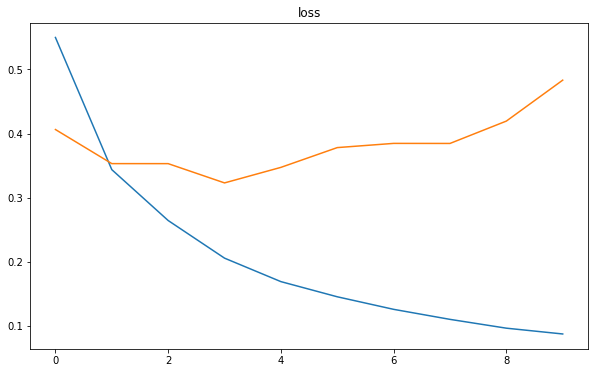

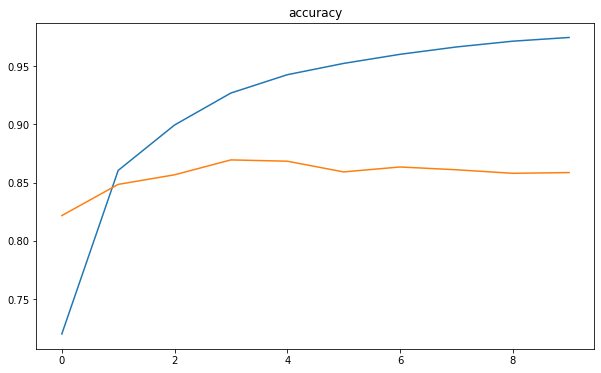

In [ ]:
plot_loss(history_LSTM)
plot_accuracy(history_LSTM)

scores = model_LSTM.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_LSTM.metrics_names[1], scores[1]*100))

In [ ]:
#GRU
model_GRU = keras.models.Sequential()
model_GRU.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_GRU.add(keras.layers.GRU(16))
model_GRU.add(keras.layers.Dense(1, activation="sigmoid"))

model_GRU.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
gru (GRU)                    (None, 16)                1344      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_GRU = model_GRU.fit(X_train_trim, y_train,epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 20s 93ms/step - loss: 0.6466 - accuracy: 0.6129 - val_loss: 0.3693 - val_accuracy: 0.8425
Epoch 2/10
196/196 [==============================] - 18s 91ms/step - loss: 0.2985 - accuracy: 0.8837 - val_loss: 0.4216 - val_accuracy: 0.8186
Epoch 3/10
196/196 [==============================] - 18s 91ms/step - loss: 0.2428 - accuracy: 0.9095 - val_loss: 0.3498 - val_accuracy: 0.8571
Epoch 4/10
196/196 [==============================] - 18s 91ms/step - loss: 0.1935 - accuracy: 0.9307 - val_loss: 0.3557 - val_accuracy: 0.8525
Epoch 5/10
196/196 [==============================] - 18s 91ms/step - loss: 0.1649 - accuracy: 0.9445 - val_loss: 0.3770 - val_accuracy: 0.8570
Epoch 6/10
196/196 [==============================] - 18s 91ms/step - loss: 0.1582 - accuracy: 0.9467 - val_loss: 0.4051 - val_accuracy: 0.8226
Epoch 7/10
196/196 [==============================] - 18s 90ms/step - loss: 0.1657 - accuracy: 0.9426 - val_loss: 0.4535 - val_accuracy:

391/391 - 10s - loss: 0.4532 - accuracy: 0.8561
accuracy: 85.61%


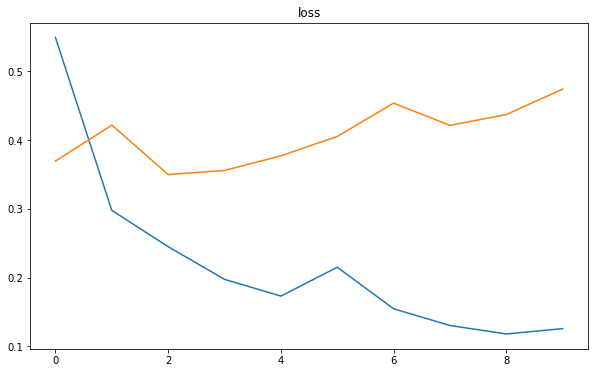

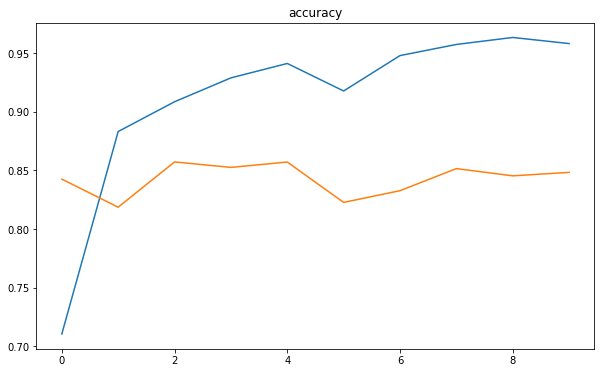

In [ ]:
plot_loss(history_GRU)

plot_accuracy(history_GRU)

scores = model_GRU.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_GRU.metrics_names[1], scores[1]*100))

##Bidirectional LSTM
Let's modify the previous code by using a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                11008     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 42s 201ms/step - loss: 0.6326 - accuracy: 0.6291 - val_loss: 0.3936 - val_accuracy: 0.8308
Epoch 2/5
196/196 [==============================] - 39s 197ms/step - loss: 0.3470 - accuracy: 0.8626 - val_loss: 0.3280 - val_accuracy: 0.8607
Epoch 3/5
196/196 [==============================] - 39s 197ms/step - loss: 0.2374 - accur

391/391 - 23s - loss: 0.3288 - accuracy: 0.8712
accuracy: 87.12%


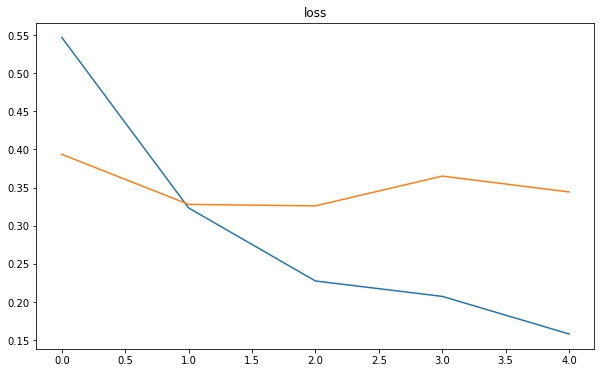

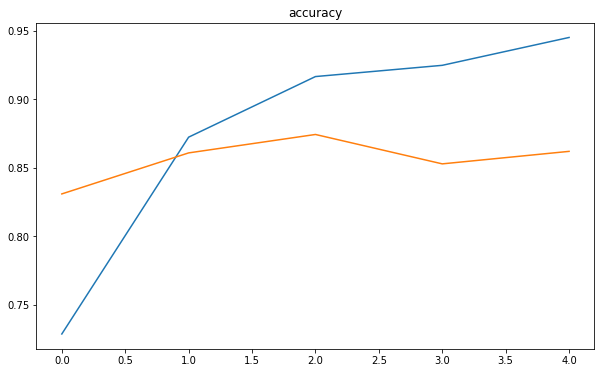

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

## Exercise 4.3: Dropout
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In Keras, to apply dropout you have to add a [keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer.

modify the code of the previous exercise adding the Dropout to the input and/or output layers. Find the Dropout probability that reduces the overfitting issue.

Is it possible to modify the values of some other hyper-parameters to mitigate overfitting? And if this is the case, explain why and perform an experimental study demonstrating your point.


In [ ]:
model_bidirectional_drop = keras.models.Sequential()
model_bidirectional_drop.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional_drop.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional_drop.add(keras.layers.Dropout(0.7))
model_bidirectional_drop.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional_drop.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional_drop.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                11008     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_drop = model_bidirectional_drop.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/5
196/196 [==============================] - 43s 204ms/step - loss: 0.6662 - accuracy: 0.5673 - val_loss: 0.3623 - val_accuracy: 0.8464
Epoch 2/5
196/196 [==============================] - 39s 199ms/step - loss: 0.3228 - accuracy: 0.8827 - val_loss: 0.3031 - val_accuracy: 0.8791
Epoch 3/5
196/196 [==============================] - 39s 200ms/step - loss: 0.2304 - accuracy: 0.9240 - val_loss: 0.2960 - val_accuracy: 0.8765
Epoch 4/5
196/196 [==============================] - 39s 200ms/step - loss: 0.1857 - accuracy: 0.9417 - val_loss: 0.3325 - val_accuracy: 0.8755
Epoch 5/5
196/196 [==============================] - 39s 199ms/step - loss: 0.1780 - accuracy: 0.9430 - val_loss: 0.3220 - val_accuracy: 0.8724


391/391 - 23s - loss: 0.3089 - accuracy: 0.8737
accuracy: 87.37%


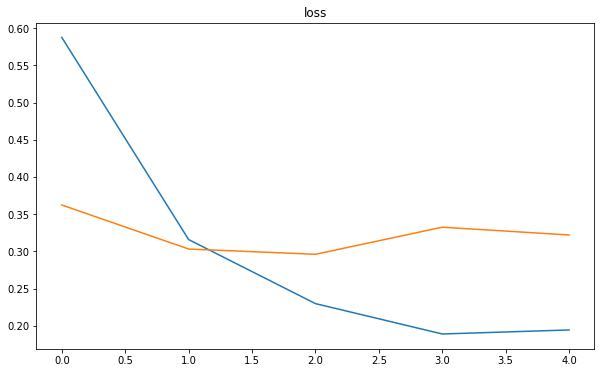

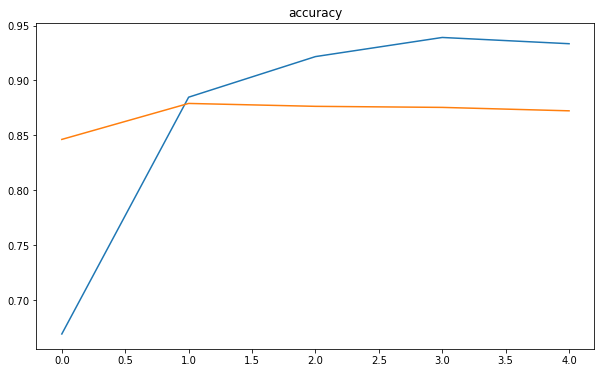

In [ ]:
plot_loss(history_drop)

plot_accuracy(history_drop)

scores = model_bidirectional_drop.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional_drop.metrics_names[1], scores[1]*100))

I tried to change different hyperparameters and I notice that by increasing the batch_size and removing the dropout layer It's possible to mitigate a little bit the overfitting.
<br>RESULTS:
<br>Bidirectional LSTM: loss: 0.3288 - accuracy: 0.8712
<br>Bidirectional LSTM Dropout(0.7) : loss: 0.3089 - accuracy: 0.8737
<br> Bidirectional LSTM Batch_Size(256): loss: 0.2973 - accuracy: 0.8797.
<br>If you look at the last plots regarding the last model described you can see that It mitigate a little bit the overfitting.


In [ ]:
model_bidirectional_2 = keras.models.Sequential()
model_bidirectional_2.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional_2.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional_2.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional_2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                11008     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_model_2 = model_bidirectional_2.fit(X_train_trim, y_train,epochs=5, batch_size=256, validation_data=(X_valid_trim, y_valid))

Epoch 1/5
98/98 [==============================] - 25s 220ms/step - loss: 0.6662 - accuracy: 0.5822 - val_loss: 0.4366 - val_accuracy: 0.8269
Epoch 2/5
98/98 [==============================] - 21s 212ms/step - loss: 0.3595 - accuracy: 0.8585 - val_loss: 0.3232 - val_accuracy: 0.8714
Epoch 3/5
98/98 [==============================] - 21s 212ms/step - loss: 0.2441 - accuracy: 0.9104 - val_loss: 0.3318 - val_accuracy: 0.8723
Epoch 4/5
98/98 [==============================] - 21s 211ms/step - loss: 0.2082 - accuracy: 0.9255 - val_loss: 0.3208 - val_accuracy: 0.8742
Epoch 5/5
98/98 [==============================] - 21s 211ms/step - loss: 0.1627 - accuracy: 0.9466 - val_loss: 0.3090 - val_accuracy: 0.8773


391/391 - 24s - loss: 0.2973 - accuracy: 0.8797
accuracy: 87.97%


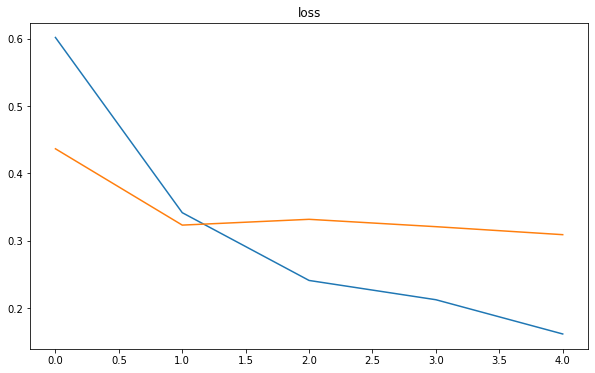

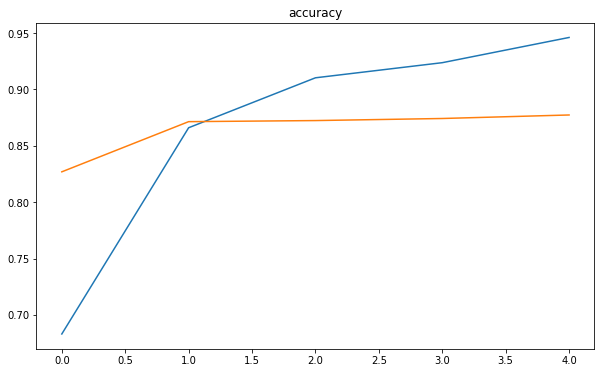

In [ ]:
plot_loss(history_model_2)

plot_accuracy(history_model_2)

scores = model_bidirectional_2.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional_2.metrics_names[1], scores[1]*100))